In [ ]:
!pip install feedparser
!pip install wordcloud
import feedparser
from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [ ]:
from nltk.corpus.reader.plaintext import PlaintextCorpusReader
import spacy
import re
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import requests
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer

# Read in documents:
---

In [ ]:
# load edible mushroom text files from drive
DOC_PATTERN = r'.*\.txt'
PATH = '/content/drive/MyDrive/Data_Science_Course/Capstones/Capstone_4/mushroom_info/ed_info/'
corpus = PlaintextCorpusReader(PATH, DOC_PATTERN)
edible = [corpus.raw(fileid) for fileid in corpus.fileids()]

In [ ]:
# load inedible mushroom text files from drive
DOC_PATTERN = r'.*\.txt'
PATH = '/content/drive/MyDrive/Data_Science_Course/Capstones/Capstone_4/mushroom_info/ined_info/'
corpus = PlaintextCorpusReader(PATH, DOC_PATTERN)
inedible = [corpus.raw(fileid) for fileid in corpus.fileids()]

In [ ]:
len(inedible)

26

# Preprocess corpus:
---

Since I'm creating a binary classifier, each document in my corpus will be labeled `Edible` or `Poisonous`. 

In [ ]:
# remove unwanted characters
edible = [desc.replace('\r', '').replace('\n', '') for desc in edible]
# remove description of poisonous lookalikes, so those descriptions don't
# get mixed in. Make all words lower case
edible = [desc.split(' Similar')[0].lower() for desc in edible]
edible[0]

"agaricus arvensis, commonly known as the horse mushroom, is a sometimes massive agaric that has a white cap, ringed stem, and pink or chocolate colored gills.cap white or cream colored, may have fine scales, first hemispherical in shape before flattening out with maturity. flesh is white, firm and thick. gills are at first white, becoming pink, then chocolate brown or blackish, free and crowded. stem is white or cream; it is slightly club-shaped and smooth or finely scaly below the ring. ring is white or cream, pendulous and superior. viewed from below, on a closed-cap specimen, it has a well-developed 'cogwheel' pattern around the stem."

In [ ]:
# remove unwanted characters
inedible = [desc.replace('\r', '').replace('\n', '') for desc in inedible]
# remove description of poisonous lookalikes, so those descriptions don't
# get mixed in. Make all words lower case
inedible = [desc.split(' Similar')[0].lower() for desc in inedible]
inedible[0]

'amanita muscaria, commonly known as the fly agaric or fly amanita, is a medium to large, fleshy agaric, with red cap, white patches, white gills, ring and a bulbous base. it grows on poor and sandy soils and the fruiting bodies emerge from the soil looking like white eggs.cap first round to hemispherical, and finally to plate-like and flat in mature specimens, often with a low, shallow depression on disk when fully expanded. surface shiny; deep scarlet, fading to orange-red or orange-yellow in older specimens. gills white, free or barely touching the stem, crowded. stem white, robust and has the slightly brittle, fibrous texture. at the base is a bulb that bears universal veil remnants in the form of two to four distinct rings or ruffs. between the basal universal veil remnants and gills are remnants of the partial veil (which covers the gills during development) in the form of a white ring. it can be quite wide and flaccid with age. amanita muscaria on the first nature web site.amani

In [ ]:
# load the spacy english module
nlp = spacy.load('en')

# tokenize each description 
ed_docs = nlp(str(edible))
ined_docs = nlp(str(inedible))

In [ ]:
# remove stop words and punctuation
ed_words = [word for word in list(ed_docs) if not word.is_stop and not word.is_punct]
ed_text = [token.text for token in ed_words]

4825

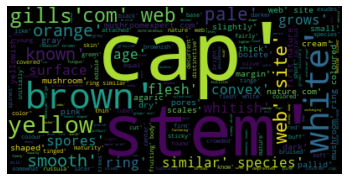

In [ ]:
# generate wordcloud image
wordcloud = WordCloud().generate(str(ed_text))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [ ]:
# remove stop words and punctuation
ined_words = [word for word in list(ined_docs) if not word.is_stop and not word.is_punct]
ined_text = [token.text for token in ined_words]

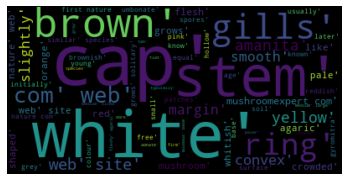

In [ ]:
# generate wordcloud image
wordcloud = WordCloud().generate(str(ined_text))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [ ]:
# add labels to each description
ed_labeled = [[desc, 'edible'] for desc in ed_docs]
ined_labeled = [[desc, 'inedible'] for desc in ined_docs]

In [ ]:
# combine into one dataframe
descriptions = pd.DataFrame(ed_labeled + ined_labeled, columns= ['description', 'group'])

descriptions.head()

In [ ]:
descriptions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 168 entries, 0 to 167
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   description  168 non-null    object
 1   group        168 non-null    object
dtypes: object(2)
memory usage: 2.8+ KB


In [ ]:
# lemmatize and remove stop words and punctuation
for i, abs in enumerate(descriptions['description']):
  descriptions.loc[i, 'description'] = ' '.join(
      [str(token) for token in abs if not token.is_punct and not token.is_stop]
  )

In [ ]:
# # remove stop words and punctuation
# descriptions['description'] = [[token for token in desc if not token.is_punct
#                                 and not token.is_stop] for desc in descriptions['description']]

In [ ]:
# descriptions.head()

,description,group
0,"[pale, orange, polypore, looks, like, agaric, ...",edible
1,"[amanita, ceciliae, known, snakeskin, grisette...",edible
2,"[amanita, fulva, known, tawny, grisette, mediu...",edible
3,"[amanita, muscaria, commonly, known, fly, agar...",edible
4,"[amanita, pantherina, known, panther, cap, pan...",edible


In [ ]:
# see how many words are in the corpus. this will play a role in 
# deciding which vectorizer to use
count = 0
for desc in descriptions['description']:
  for token in desc:
    count += 1
count

83975

Since the corpus only has about 8,400 words, it is unlikely that word2vec will be a good choice. I'll try TF-IDF and look at the results. 

In [ ]:
descriptions

In [ ]:
# define features and target variable 
X = descriptions['description']
y = np.where((descriptions['group'] == 'inedible'), 1, 0)

# split into training and testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2)

In [ ]:
vectorizer = TfidfVectorizer(
    use_idf=True, max_df=.5, min_df=2, smooth_idf=True
)

train = vectorizer.fit_transform(X_train)
test = vectorizer.transform(X_test)

train_df = pd.DataFrame(train.toarray(), columns=vectorizer.get_feature_names())
test_df = pd.DataFrame(test.toarray(), columns=vectorizer.get_feature_names())
train_df.head()

,10,absent,acid,acidic,adnate,adnexe,agaricus,age,alboviolaceu,alder,amanita,america,angular,apex,appear,appearance,area,arise,armillaria,arrange,associate,attach,attachment,autumn,away,background,bag,bald,ball,band,basal,base,bay,bear,beech,beige,bell,beneath,birch,bitter,...,upwards,usually,variable,vary,vase,veil,vein,velar,velvet,velvety,versipelle,vinaceous,violet,viscid,vivid,vividly,volva,volval,walnut,wart,warty,wavy,weather,webcap,wet,whitish,wide,wikipedia,wine,wood,woodland,woods,woolly,work,wrinkle,wrinkled,www,yellowish,young,zone
0,0.0,0.0,0.0,0.000000,0.00000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.114935,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.126874,0.0,0.000000,0.0,0.0,0.000000,0.0,0.061061,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.310472,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.126874,0.0,0.0,0.0,0.132034,0.0,0.070248,0.000000,0.082951,0.000000
1,0.0,0.0,0.0,0.000000,0.00000,0.0,0.0,0.0,0.000000,0.0,0.318702,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.118553,0.126971,0.0,0.291436,0.0,0.0,0.122498,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.000000,0.0,0.091803,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.138243,0.276486,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
2,0.0,0.0,0.0,0.000000,0.00000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.110539,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.087745,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.073151,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
3,0.0,0.0,0.0,0.080382,0.05338,0.0,0.0,0.0,0.090332,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.071227,0.0,0.0,0.0,0.0,0.080382,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.071064,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.071227,...,0.0,0.117966,0.0,0.000000,0.0,0.106759,0.0,0.0,0.0,0.0,0.0,0.0,0.516798,0.0,0.076831,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.076831,0.073828,0.0,0.040877,0.0,0.076831,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.096538,0.096538,0.054379
4,0.0,0.0,0.0,0.110357,0.00000,0.0,0.0,0.0,0.372053,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.110357,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.048782,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.094639,0.0,0.073285,0.0,0.0,0.0,0.0,0.0,0.0,0.202719,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.074657


In [ ]:
lr = LogisticRegression()
rfc = RandomForestClassifier()
gbc = GradientBoostingClassifier()

lr.fit(train_df, y_train)
rfc.fit(train_df, y_train)
gbc.fit(train_df, y_train)

print("----------------------Logistic Regression Scores----------------------")
print('Training set score:', lr.score(train_df, y_train))
print('\nTest set score:', lr.score(test_df, y_test))

print("----------------------Random Forest Scores----------------------")
print('Training set score:', rfc.score(train_df, y_train))
print('\nTest set score:', rfc.score(test_df, y_test))

print("----------------------Gradient Boosting Scores----------------------")
print('Training set score:', gbc.score(train_df, y_train))
print('\nTest set score:', gbc.score(test_df, y_test))

----------------------Logistic Regression Scores----------------------
Training set score: 0.911504424778761

Test set score: 0.5517241379310345
----------------------Random Forest Scores----------------------
Training set score: 1.0

Test set score: 0.5862068965517241
----------------------Gradient Boosting Scores----------------------
Training set score: 1.0

Test set score: 0.6551724137931034


In [ ]:
10//3

3